<a href="https://colab.research.google.com/github/ChristianFel7/Python-para-Data-Science/blob/main/Spark_processamento_de_linguagem_natural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

base de dados utilizada:
[Base](https://cdn3.gnarususercontent.com.br/2275-spark-processamento-linguagem-natural/01/imdb-reviews-pt-br.csv)

In [1]:
!pip install pyspark

In [2]:
from pyspark.sql import SparkSession
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
import string
import pyspark.sql.functions as f
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import Tokenizer
from nltk.corpus import stopwords

In [3]:
spark = SparkSession.builder \
    .master('local[*]') \
    .appName("analise_nlp") \
    .getOrCreate()

In [4]:
dados = spark.read.csv("/content/imdb-reviews-pt-br.csv",
                       escape="\"",
                       header=True,
                       inferSchema=True)

In [5]:
dados.show()

+---+--------------------+--------------------+---------+
| id|             text_en|             text_pt|sentiment|
+---+--------------------+--------------------+---------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|
|  2|This is an exampl...|Este é um exemplo...|      neg|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|
|  6|A funny thing hap...|Uma coisa engraça...|      neg|
|  7|This German horro...|Este filme de ter...|      neg|
|  8|Being a long-time...|Sendo um fã de lo...|      neg|
|  9|"Tokyo Eyes" tell...|"Tokyo Eyes" fala...|      neg|
| 10|Wealthy horse ran...|Fazendeiros ricos...|      neg|
| 11|Cage plays a drun...|Cage interpreta u...|      neg|
| 12|First of all, I w...|Primeiro de tudo,...|      neg|
| 13|So tell me - what...|Então me diga - q...|      neg|
| 14|A big disappointm...|Uma grande decepç...|      neg|
| 15|This film

In [6]:
dados.toPandas()

,id,text_en,text_pt,sentiment
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,neg
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",neg
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,neg
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,neg
...,...,...,...,...
49454,49456,"Seeing as the vote average was pretty low, and...","Como a média de votos era muito baixa, e o fat...",pos
49455,49457,"The plot had some wretched, unbelievable twist...",O enredo teve algumas reviravoltas infelizes e...,pos
49456,49458,I am amazed at how this movieand most others h...,Estou espantado com a forma como este filme e ...,pos
49457,49459,A Christmas Together actually came before my t...,A Christmas Together realmente veio antes do m...,pos


In [7]:
dados.count()

49459

In [8]:
len(dados.columns)

4

In [9]:
dados.printSchema()

root
 |-- id: integer (nullable = true)
 |-- text_en: string (nullable = true)
 |-- text_pt: string (nullable = true)
 |-- sentiment: string (nullable = true)



In [10]:
dados.limit(5).toPandas()

,id,text_en,text_pt,sentiment
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,neg
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",neg
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,neg
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,neg


In [11]:
dados.filter(dados.id == 190).select('text_pt').show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text_pt                                                                                                                          

In [12]:
dados.filter(dados.id == 12427).select('text_pt').show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text_pt                                                                                                                                                                                                                                                                        

Limpando e processando os dados

In [13]:
amostra = dados.select('text_pt').sample(fraction=0.1, seed=101)
tudo = [texto['text_pt'] for texto in amostra.collect()]


In [14]:
wordcloud = WordCloud(
    collocations=False,
    background_color='white',
    width=1000,
    height=600,
    prefer_horizontal=1
).generate(str(tudo))

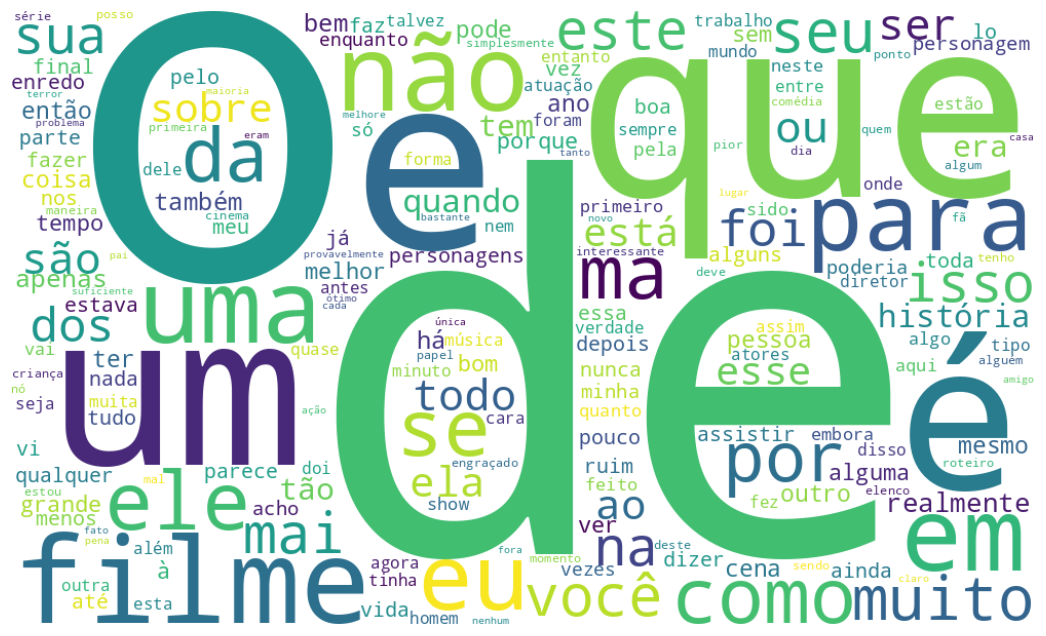

In [15]:
plt.figure(figsize=(20, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [16]:
amostra = spark.createDataFrame([
                ("Oi, JP! Blz?",),
                ("$$$\\ |~ Parabéns ~| \\$$$",),
                ("(#amovc #paz&amor ^.^)",),
                ("\"bora *_* \"",),
                ("=>->'...``` vc foi selecionad@ ´´´...'<=<-",),
                ("{comprar: arroz; feijão e pepino} //",),
                ("!\"#$&'()*+,-./:;<=>?@[\]^_`{|}~",),
                ("ana@gmail.com",)
        ], ["textos"])

In [17]:
amostra = amostra.withColumn("texto_regex", f.regexp_replace("textos", "[\$#,\"!%&'()*+-./;:<=>?@^_`´{|}~\\\\]", ""))
amostra.show(truncate = False)

+------------------------------------------+------------------------------+
|textos                                    |texto_regex                   |
+------------------------------------------+------------------------------+
|Oi, JP! Blz?                              |Oi JP Blz                     |
|$$$\ |~ Parabéns ~| \$$$                  |  Parabéns                    |
|(#amovc #paz&amor ^.^)                    |amovc pazamor                 |
|"bora *_* "                               |bora                          |
|=>->'...``` vc foi selecionad@ ´´´...'<=<-| vc foi selecionad            |
|{comprar: arroz; feijão e pepino} //      |comprar arroz feijão e pepino |
|!"#$&'()*+,-./:;<=>?@[\]^_`{|}~           |[]                            |
|ana@gmail.com                             |anagmailcom                   |
+------------------------------------------+------------------------------+



In [18]:
amostra = amostra.withColumn("texto_limpo", f.trim(amostra.texto_regex))
amostra.show(truncate = False)

+------------------------------------------+------------------------------+-----------------------------+
|textos                                    |texto_regex                   |texto_limpo                  |
+------------------------------------------+------------------------------+-----------------------------+
|Oi, JP! Blz?                              |Oi JP Blz                     |Oi JP Blz                    |
|$$$\ |~ Parabéns ~| \$$$                  |  Parabéns                    |Parabéns                     |
|(#amovc #paz&amor ^.^)                    |amovc pazamor                 |amovc pazamor                |
|"bora *_* "                               |bora                          |bora                         |
|=>->'...``` vc foi selecionad@ ´´´...'<=<-| vc foi selecionad            |vc foi selecionad            |
|{comprar: arroz; feijão e pepino} //      |comprar arroz feijão e pepino |comprar arroz feijão e pepino|
|!"#$&'()*+,-./:;<=>?@[\]^_`{|}~           |[]

limpando nossos dados

In [19]:
dados = dados.withColumn("texto_regex", f.regexp_replace("text_en", "[\$#,\"!%&'()*+-./;;<=>?@^_`´{|}~\\\\]", ""))

dados.limit(2).show(truncate = False)

+---+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [20]:
dados = dados.withColumn("texto_limpo", f.trim(dados.texto_regex))

In [21]:
dados.limit(2).show()

+---+--------------------+--------------------+---------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|
+---+--------------------+--------------------+---------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|Once again Mr Cos...|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|This is an exampl...|
+---+--------------------+--------------------+---------+--------------------+--------------------+



In [22]:
from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(inputCol = "texto_limpo", outputCol = "tokens")

tokenizado = tokenizer.transform(dados)

In [23]:
tokenizado.select("texto_limpo", "tokens").show()

+--------------------+--------------------+
|         texto_limpo|              tokens|
+--------------------+--------------------+
|Once again Mr Cos...|[once, again, mr,...|
|This is an exampl...|[this, is, an, ex...|
|First of all I ha...|[first, of, all, ...|
|Not even the Beat...|[not, even, the, ...|
|Brass pictures mo...|[brass, pictures,...|
|A funny thing hap...|[a, funny, thing,...|
|This German horro...|[this, german, ho...|
|Being a longtime ...|[being, a, longti...|
|Tokyo Eyes tells ...|[tokyo, eyes, tel...|
|Wealthy horse ran...|[wealthy, horse, ...|
|Cage plays a drun...|[cage, plays, a, ...|
|First of all I wo...|[first, of, all, ...|
|So tell me  what ...|[so, tell, me, , ...|
|A big disappointm...|[a, big, disappoi...|
|This film is abso...|[this, film, is, ...|
|Heres a decidedly...|[heres, a, decide...|
|At the bottom end...|[at, the, bottom,...|
|Earth has been de...|[earth, has, been...|
|Many people are s...|[many, people, ar...|
|New York family i...|[new, york

In [24]:
from pyspark.sql.types import IntegerType
countTokens = f.udf(lambda tokens: len(tokens), IntegerType())

In [25]:
tokenizado.select("texto_limpo", "tokens").withColumn("Freq_tokens", countTokens(f.col("tokens"))).show()

+--------------------+--------------------+-----------+
|         texto_limpo|              tokens|Freq_tokens|
+--------------------+--------------------+-----------+
|Once again Mr Cos...|[once, again, mr,...|        168|
|This is an exampl...|[this, is, an, ex...|        232|
|First of all I ha...|[first, of, all, ...|        215|
|Not even the Beat...|[not, even, the, ...|        308|
|Brass pictures mo...|[brass, pictures,...|        238|
|A funny thing hap...|[a, funny, thing,...|        115|
|This German horro...|[this, german, ho...|        156|
|Being a longtime ...|[being, a, longti...|        136|
|Tokyo Eyes tells ...|[tokyo, eyes, tel...|        129|
|Wealthy horse ran...|[wealthy, horse, ...|        160|
|Cage plays a drun...|[cage, plays, a, ...|        109|
|First of all I wo...|[first, of, all, ...|        333|
|So tell me  what ...|[so, tell, me, , ...|        243|
|A big disappointm...|[a, big, disappoi...|        110|
|This film is abso...|[this, film, is, ...|     

removendo stopwords

In [26]:
import nltk
nltk.download("stopwords")

from nltk.corpus import stopwords
stop_A = stopwords.words("portuguese")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [27]:
from pyspark.ml.feature import StopWordsRemover
stop_B = StopWordsRemover.loadDefaultStopWords("portuguese")

In [28]:
remover = StopWordsRemover(inputCol = "tokens", outputCol= "texto_final")
feature_data  = remover.transform(tokenizado)


In [29]:
feature_data.select("tokens", "texto_final")\
                    .withColumn("Freq_tokens", countTokens(f.col("tokens")))\
                    .withColumn("Fre_tokens_limpos", countTokens(f.col("texto_final"))).show()

+--------------------+--------------------+-----------+-----------------+
|              tokens|         texto_final|Freq_tokens|Fre_tokens_limpos|
+--------------------+--------------------+-----------+-----------------+
|[once, again, mr,...|[mr, costner, dra...|        168|               73|
|[this, is, an, ex...|[example, majorit...|        232|              131|
|[first, of, all, ...|[first, hate, mor...|        215|              111|
|[not, even, the, ...|[even, beatles, w...|        308|              169|
|[brass, pictures,...|[brass, pictures,...|        238|              140|
|[a, funny, thing,...|[funny, thing, ha...|        115|               52|
|[this, german, ho...|[german, horror, ...|        156|               74|
|[being, a, longti...|[longtime, fan, j...|        136|               73|
|[tokyo, eyes, tel...|[tokyo, eyes, tel...|        129|               75|
|[wealthy, horse, ...|[wealthy, horse, ...|        160|               99|
|[cage, plays, a, ...|[cage, plays, dr

Vetorização das palavras

In [30]:
from pyspark.ml.feature import CountVectorizer

cv = CountVectorizer(inputCol = "texto_final", outputCol = "CountVec")

model = cv.fit(feature_data)

countVectorizer_features = model.transform(feature_data)

countVectorizer_features.select('texto_final', 'CountVec').limit(5).show()#truncate=False

+--------------------+--------------------+
|         texto_final|            CountVec|
+--------------------+--------------------+
|[mr, costner, dra...|(221187,[0,7,8,11...|
|[example, majorit...|(221187,[1,2,3,8,...|
|[first, hate, mor...|(221187,[0,2,4,11...|
|[even, beatles, w...|(221187,[0,1,2,4,...|
|[brass, pictures,...|(221187,[1,3,5,8,...|
+--------------------+--------------------+



Alternativa para o countvector: Hashing TF

In [31]:
from pyspark.ml.feature import HashingTF

In [32]:
hashingTF = HashingTF(inputCol="texto_final", outputCol="hashingTF")
hashingTF.setNumFeatures(50)

HashingTF_4672e659c928

In [33]:
HTFfeaturizedData = hashingTF.transform(countVectorizer_features)

In [34]:
HTFfeaturizedData.select("texto_final", "hashingTF").limit(5).show()

+--------------------+--------------------+
|         texto_final|           hashingTF|
+--------------------+--------------------+
|[mr, costner, dra...|(50,[0,5,6,7,8,10...|
|[example, majorit...|(50,[0,1,2,3,4,5,...|
|[first, hate, mor...|(50,[0,1,2,3,5,6,...|
|[even, beatles, w...|(50,[0,1,2,3,4,5,...|
|[brass, pictures,...|(50,[0,1,2,3,4,5,...|
+--------------------+--------------------+



TF-IDF

In [35]:
from pyspark.ml.feature import IDF

idf = IDF(inputCol="hashingTF", outputCol="features")

idfModel = idf.fit(HTFfeaturizedData)

TFIDFfeaturizedData = idfModel.transform(HTFfeaturizedData)

In [36]:
TFIDFfeaturizedData.select('texto_final', 'features').limit(5).show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [37]:
TFIDFfeaturizedData.groupBy('sentiment').count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
|      pos|24694|
|      neg|24765|
+---------+-----+



In [38]:
from pyspark.ml.feature import StringIndexer

In [39]:
from pyspark.ml.feature import StringIndexer

stringindexer = StringIndexer(inputCol="sentiment", outputCol="label")

dados = stringindexer.fit(dados).transform(dados)

In [40]:
dados.groupBy(['sentiment', 'label']).count().show()

+---------+-----+-----+
|sentiment|label|count|
+---------+-----+-----+
|      pos|  1.0|24694|
|      neg|  0.0|24765|
+---------+-----+-----+



Possível fazer de maneira mais automática usando a função pipeline

In [41]:
from pyspark.ml import Pipeline

tokenizer = Tokenizer(inputCol = "texto_limpo", outputCol = "tokens")

stopwords = StopWordsRemover(inputCol="tokens", outputCol="texto_final")

hashingTF = HashingTF(inputCol=stopwords.getOutputCol(), outputCol="HTF", numFeatures=1000)

tfidf = IDF(inputCol="HTF", outputCol="features")

pipeline = Pipeline(stages = [tokenizer, stopwords, hashingTF, tfidf])

In [42]:
dados_transformados = pipeline.fit(dados).transform(dados)

In [43]:
dados_transformados.limit(5).show()

+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|label|              tokens|         texto_final|                 HTF|            features|
+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|Once again Mr Cos...|  0.0|[once, again, mr,...|[mr, costner, dra...|(1000,[10,21,34,4...|(1000,[10,21,34,4...|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|This is an exampl...|  0.0|[this, is, an, ex...|[example, majorit...|(1000,[0,3,11,12,...|(1000,[0,3,11,12,...|
|  3|First of all I ha...|Primeiro de tudo ...|   

Árvores de decisão - conjunto de regras para classificar

In [44]:
featureDF = dados_transformados.select(['features', 'label'])
featureDF.limit(5).show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [45]:
featureDF.printSchema()

root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)



In [47]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier

tokenizer = Tokenizer(inputCol = "texto_limpo", outputCol = "tokens")

stopwords = StopWordsRemover(inputCol="tokens", outputCol="texto_final")

hashingTF = HashingTF(inputCol=stopwords.getOutputCol(), outputCol="HTF", numFeatures=1000)

tfidf = IDF(inputCol="HTF", outputCol="features")

dt = DecisionTreeClassifier(featuresCol='features', labelCol='label', maxDepth=10)

pipeline = Pipeline(stages = [tokenizer, stopwords, hashingTF, tfidf, dt])

In [48]:
train, test = dados.randomSplit([0.7, 0.3], seed = 101)
dt_model = pipeline.fit(train)
predictions = dt_model.transform(test)

In [49]:
predictions.show()

+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+----------+
| id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|label|              tokens|         texto_final|                 HTF|            features|  rawPrediction|         probability|prediction|
+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+----------+
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|Brass pictures mo...|Brass pictures mo...|  0.0|[brass, pictures,...|[brass, pictures,...|(1000,[3,6,7,11,3...|(1000,[3,6,7,11,3...| [369.0,1108.0]|[0.24983073798239...|       1.0|
|  6|A funny thing hap...|Uma coisa engraça...| 

Explicando os resultados - testes e métricas

In [50]:
predictions.select(['label', 'prediction']).show()

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows



In [53]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
acuracia = evaluator.evaluate(predictions)

In [54]:
print(acuracia)

0.6724696356275304


In [56]:
nova_base = spark.createDataFrame([
        (1, "This is without doubt the worst movie i have ever seen, I hated the acting of the actor."),
        (0, "I loved the movie, excellent acting!"),
    ], ["id", "texto_limpo"])

In [57]:
nova_class = dt_model.transform(nova_base)

In [58]:
nova_class.show()

+---+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+----------+
| id|         texto_limpo|              tokens|         texto_final|                 HTF|            features|rawPrediction|         probability|prediction|
+---+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+----------+
|  1|This is without d...|[this, is, withou...|[without, doubt, ...|(1000,[35,43,269,...|(1000,[35,43,269,...|   [32.0,7.0]|[0.82051282051282...|       0.0|
|  0|I loved the movie...|[i, loved, the, m...|[loved, movie,, e...|(1000,[185,543,73...|(1000,[185,543,73...|[173.0,839.0]|[0.17094861660079...|       1.0|
+---+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+----------+

